In [11]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load the MassiveNuS convergence dataset

See http://www.columbialensing.org/#massivenus for more information

## Shape catalog

From the HSC-XMM field shape catalog generate:
- noise covariance matrix
- survey mask
- e1, e2 maps

In [12]:
from astropy.table import Table
from astropy.io import fits

In [13]:
cat = Table.read('../data/193145.fits')

In [21]:
cat.keys()

['object_id',
 'object_id_isnull',
 'ishape_hsm_regauss_derived_shape_weight',
 'ishape_hsm_regauss_derived_shape_weight_isnull',
 'ishape_hsm_regauss_derived_shear_bias_m',
 'ishape_hsm_regauss_derived_shear_bias_m_isnull',
 'ishape_hsm_regauss_derived_shear_bias_c1',
 'ishape_hsm_regauss_derived_shear_bias_c1_isnull',
 'ishape_hsm_regauss_derived_shear_bias_c2',
 'ishape_hsm_regauss_derived_shear_bias_c2_isnull',
 'ishape_hsm_regauss_derived_sigma_e',
 'ishape_hsm_regauss_derived_sigma_e_isnull',
 'ishape_hsm_regauss_derived_rms_e',
 'ishape_hsm_regauss_derived_rms_e_isnull',
 'ira',
 'ira_isnull',
 'idec',
 'idec_isnull',
 'ishape_hsm_regauss_e1',
 'ishape_hsm_regauss_e1_isnull',
 'ishape_hsm_regauss_e2',
 'ishape_hsm_regauss_e2_isnull',
 'object_id_2',
 'object_id_2_isnull',
 'photoz_mean',
 'photoz_mean_isnull',
 'photoz_mode',
 'photoz_mode_isnull',
 'photoz_median',
 'photoz_median_isnull',
 'photoz_best',
 'photoz_best_isnull',
 'photoz_mc',
 'photoz_mc_isnull',
 'photoz_conf_m

In [15]:
survey_cut = (cat['ira']>35.5) * (cat['ira']<38.5) * (cat['idec']>-6) * (cat['idec']<-3)

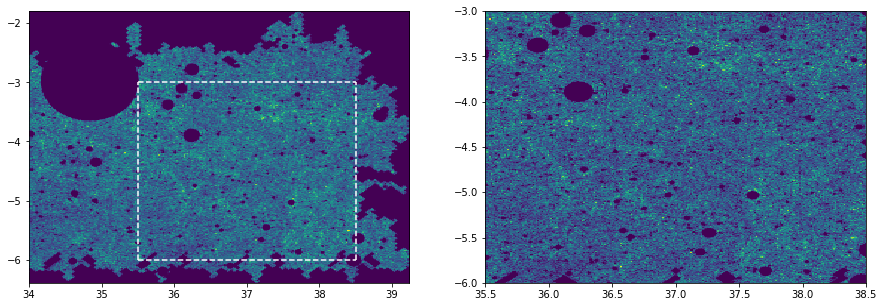

In [16]:
figure(figsize=[15,5])
subplot(121)
hist2d(cat['ira'], cat['idec'], 256);
hlines(y=-3,xmin=35.5, xmax=38.5, color='w', linestyle='--')
hlines(y=-6,xmin=35.5, xmax=38.5, color='w', linestyle='--')
vlines(x=35.5,ymin=-6, ymax=-3, color='w', linestyle='--')
vlines(x=38.5,ymin=-6, ymax=-3, color='w', linestyle='--')
subplot(122)
hist2d(cat['ira'][survey_cut], cat['idec'][survey_cut], 256);

cat = cat[survey_cut]

Ensure that our assumption of redshift mean is correct

Mean redshift 0.9701822


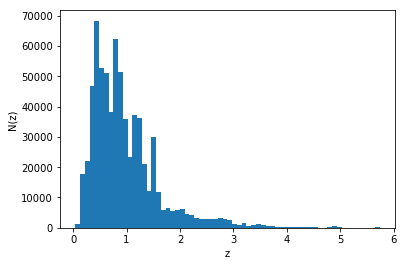

In [17]:
hist(cat['photoz_best'], 64);
xlabel('z')
ylabel('N(z)')
print('Mean redshift', np.mean(cat['photoz_best']))

Bin the catalog using [lenspack](https://github.com/CosmoStat/lenspack/tree/master/lenspack).

In [18]:
from lenspack.utils import bin2d

# Compute boundaries of the field so that it fits in a 360x360 map
# MassiveNuS maps beging 512x512 with 0.4 arcmin resolution, we resize them to 360x360
resolution = 512/360*0.4
width = 360
size = width * resolution / 60.

ra = median(cat['ira'])
dec = median(cat['idec'])
extent = [ra - size/2, ra + size/2, dec - size/2, dec + size/2]

**Number of galaxy per pixel map**

In [19]:
from quarks2cosmos.utils import get_extend_radec

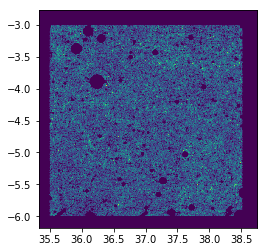

In [32]:
n_gal_map = bin2d(cat['ira'], cat['idec'],
                  npix=width,
                  extent=extent)

imshow(n_gal_map, origin='lower', extent=get_extend_radec(resolution, width,ra, dec))

**Survey mask**

Text(0.5,1,'binary mask')

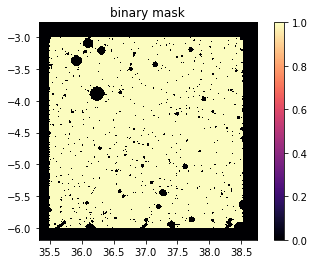

In [39]:
m = n_gal_map == 0
mask = 1.-m
imshow(mask, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
colorbar()
#xlim(gca().get_xlim()[::-1])
title("binary mask")

**Ellipticity maps**

Text(0.5,1,'e2')

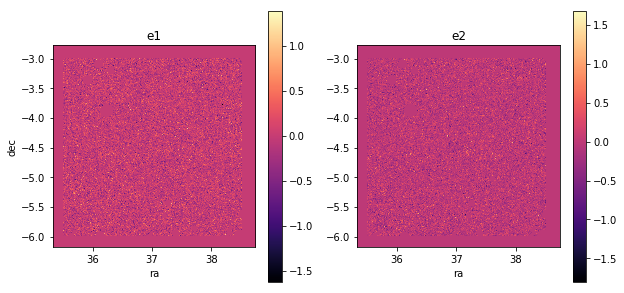

In [31]:
# Bin ellipticity components based on galaxy position into a 360x360 map
e1map, e2map = bin2d(cat['ira'], cat['idec'], 
                     v=(cat['ishape_hsm_regauss_e1'], cat['ishape_hsm_regauss_e2']), 
                     npix=width,
                     extent=extent)

figure(figsize=[10,5])
subplot(121)
imshow(e1map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
#xlim(gca().get_xlim()[::-1])
colorbar()
xlabel('ra')
ylabel('dec')
title('e1')

subplot(122)
imshow(e2map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
colorbar()
#xlim(gca().get_xlim()[::-1])
xlabel('ra')
title('e2')

**Noise covariance matrix**

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5,1,'$\\sigma_{e_2}/\\sqrt{N_{gal}}$')

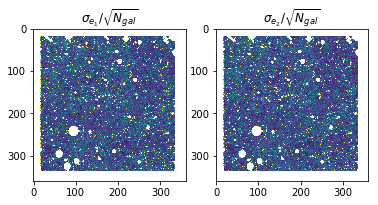

In [45]:
sigma_e1 = np.std(cat['ishape_hsm_regauss_e1'])/np.sqrt(n_gal_map)
sigma_e2 = np.std(cat['ishape_hsm_regauss_e2'])/np.sqrt(n_gal_map)

subplot(121)
imshow(sigma_e1)
title(r'$\sigma_{e_1}/\sqrt{N_{gal}}$')

subplot(122)
imshow(sigma_e2)
title(r'$\sigma_{e_2}/\sqrt{N_{gal}}$')

## Kaiser-Squires solution

Use the first mass-mapping technique [Kaiser-Squires (1993)](https://ui.adsabs.harvard.edu/abs/1993ApJ...404..441K/abstract)

## Wiener filter solution

Get the maximum-a-posteriori (MAP), assuming a Gaussian prior that is characterised by the theoretical power spectrum.

1) The likelihood

2) The prior

**MAP**